In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ttest_ind

In [4]:
#
file_path = "/home/nccpml/DATA2/hanbyeol/TEC/gcam_res08/"
file_list = sorted([f for f in os.listdir(file_path) 
             if f.startswith("gcamplus_result_TEC_v") and f.endswith(".txt")])
file_list

FileNotFoundError: [Errno 2] No such file or directory: '/home/nccpml/DATA2/hanbyeol/TEC/gcam_res08/'

In [102]:
# 데이터 프레임을 저장할 빈 리스트 생성
dfs = []

# 파일 리스트에 대해 반복하며 데이터 프레임 생성 및 리스트에 추가
for file in sorted(file_list):
    df = pd.read_csv(file_path + file, sep='\t')
    df = df.sort_values(by='Normalized_Weight', ascending=False).reset_index(drop=True)
    # df = df.head(n=50)
    dfs.append(df)

dfs[0]

,TumorCell,TEC,Normalized_Weight
0,VIP,RAMP2,1.000000
1,AVP,RAMP2,0.994312
2,PTH2,RAMP2,0.988620
3,GCG,RAMP2,0.982931
4,GHRH,RAMP2,0.982520
...,...,...,...
13155,SMAD3,UBB,0.001488
13156,ADRB2,UBC,0.000997
13157,TGFBR1,UBB,0.000906
13158,TGFBR2,UBB,0.000323


In [103]:
int(ref_value)

658

### Z-Score 확인

In [104]:
# 파일 리스트에 대해 반복하며 데이터 프레임 생성 및 리스트에 추가
ref_value = int(len(dfs[0].index)*0.05)

dfs = []

for file in sorted(file_list):
    df = pd.read_csv(file_path + file, sep='\t')
    df = df.sort_values(by='Normalized_Weight', ascending=False).reset_index(drop=True)
    df = df.head(n=ref_value)
    dfs.append(df)

# 유전자 pair의 등장 횟수 계산
pair_count = {}
pair_weights = {}

for df in dfs:
    for index, row in df.iterrows():
        pair = (row['TumorCell'], row['TEC'])
        if pair not in pair_count:
            pair_count[pair] = 0
            pair_weights[pair] = []
        pair_count[pair] += 1
        pair_weights[pair].append(row['Normalized_Weight'])

# 공통 유전자 쌍 데이터 프레임 생성
common_pairs = [(pair[0], pair[1], pair_count[pair]) for pair in pair_count if pair_count[pair] > 1]
common_df = pd.DataFrame(common_pairs, columns=['TumorCell', 'TEC', 'Count'])

# Z 점수 계산 및 통합
z_score_columns = {f'Z_Score_{i+1}': [] for i in range(len(dfs))}

for pair in common_df.itertuples():
    pair_key = (pair.TumorCell, pair.TEC)
    for i, df in enumerate(dfs):
        mean_weight = df['Normalized_Weight'].mean()
        std_weight = df['Normalized_Weight'].std()
        weight = df[(df['TumorCell'] == pair_key[0]) & (df['TEC'] == pair_key[1])]['Normalized_Weight'].values
        if weight.size > 0:
            z_score = (weight[0] - mean_weight) / std_weight
            z_score_columns[f'Z_Score_{i+1}'].append(z_score)
        else:
            z_score_columns[f'Z_Score_{i+1}'].append(np.nan)

for col in z_score_columns:
    common_df[col] = z_score_columns[col]

# 평균 Normalized_Weight 계산 및 추가
mean_weights = []
for pair in common_df.itertuples():
    pair_key = (pair.TumorCell, pair.TEC)
    all_weights = []
    for df in dfs:
        weight = df[(df['TumorCell'] == pair_key[0]) & (df['TEC'] == pair_key[1])]['Normalized_Weight'].values
        if weight.size > 0:
            all_weights.append(weight[0])
    mean_weights.append(np.mean(all_weights) if all_weights else np.nan)

common_df['Mean_Normalized_Weight'] = mean_weights
    
# Z 점수의 절댓값을 취한 후 평균 계산
common_df['Mean_Abs_Z_Score'] = common_df[[col for col in z_score_columns]].abs().mean(axis=1)

# 공통 Count 순으로 데이터 프레임 정렬
common_df = common_df.sort_values(by='Mean_Normalized_Weight', ascending=False).reset_index(drop=True)

# 출력 결과 확인
common_df.head(30)


,TumorCell,TEC,Count,Z_Score_1,Z_Score_2,Z_Score_3,Z_Score_4,Z_Score_5,Z_Score_6,Z_Score_7,Z_Score_8,Z_Score_9,Z_Score_10,Mean_Normalized_Weight,Mean_Abs_Z_Score
0,ITGAM,F10,10,2.736087,3.549001,5.576372,6.413421,-0.128896,2.965007,4.561956,1.255197,4.245793,7.546874,0.834507,3.897860
1,ITGB2,F10,10,2.740470,3.374216,4.917441,5.935374,-0.157757,2.773242,4.196951,1.956693,3.816548,6.404314,0.809096,3.627301
2,GCG,RAMP2,10,4.504141,3.547469,0.043776,1.766852,-0.498644,4.508616,4.034591,4.122625,4.393812,2.423328,0.751656,2.984385
3,PTH2,RAMP2,10,4.552343,3.705516,-0.024341,1.897313,-0.513579,4.512370,3.972998,4.093889,4.186302,2.505255,0.751509,2.996390
4,AVP,RAMP2,10,4.600566,3.863532,-0.092458,2.027772,-0.528511,4.516153,3.911447,4.065169,3.978811,2.587152,0.751362,3.017157
5,VIP,RAMP2,10,4.648758,4.021569,-0.160583,2.158213,-0.543443,4.519952,3.849894,4.036446,3.771301,2.669071,0.751215,3.037923
6,CGA,RAMP2,10,4.470767,3.401432,0.095619,1.662618,-0.485482,4.493489,4.080369,4.103294,4.531423,2.369949,0.750649,2.969444
7,ADM,RAMP2,10,4.480724,3.290405,0.099912,1.634972,-0.477495,4.445275,4.080014,3.943592,4.464892,2.399898,0.746272,2.931718
8,CALCA,RAMP2,10,4.490708,3.179370,0.104199,1.607346,-0.469511,4.397051,4.079672,3.783877,4.398354,2.429865,0.741894,2.893995
9,GHRH,RAMP2,10,4.500656,3.068337,0.108484,1.579699,-0.461527,4.348840,4.079329,3.624177,4.331797,2.459807,0.737516,2.856265


### Statistical analysis
7개의 결과 Normalized_Weight에 대한 통계적 분석

In [105]:
## 모든 클래스 한번에 
# 파일 이름 패턴에 따라 파일 리스트 생성
path = '/home/nccpml/DATA2/hanbyeol/TEC/gcam_res08/'
save_path = "/home/nccpml/DATA2/hanbyeol/TEC/CCI_res08/"

if not os.path.exists(save_path):
    os.makedirs(save_path)

class_names = ['TEC', 'NEC', 'Myeloid', 'Epithelial', 'Fibro_Peri', 'TandNK', 'B']

for cell in class_names:
    file_list = [f for f in os.listdir(path) 
                 if f.startswith("gcamplus_result_" + cell + "_v") and f.endswith(".txt")]
    
    # 데이터 프레임을 저장할 빈 리스트 생성
    dfs = []
        
    # 파일 리스트에 대해 반복하며 데이터 프레임 생성 및 리스트에 추가
    for file in sorted(file_list):
        df = pd.read_csv(path + file, sep='\t')
        df = df.sort_values(by='Normalized_Weight', ascending=False).reset_index(drop=True)
        df = df.head(n=ref_value)
        dfs.append(df)
        
    # 유전자 pair의 등장 횟수 계산
    gene_pairs = []
    tumor = df.columns[0]
    other = df.columns[1]
    
    # TumorCell, TEC pair의 수 계산
    for df in dfs:
        for index, row in df.iterrows():
            gene_pairs.append((row[tumor], row[other]))
    
    # 리스트를 데이터 프레임으로 변환
    common_pairs_df = pd.DataFrame(gene_pairs, columns=[tumor, other])
    
    # TumorCell과 TEC pair의 빈도수 계산
    common_pairs_df['Count'] = common_pairs_df.groupby([tumor, other])[other].transform('count')
    
    # 중복 제거
    common_pairs_df = common_pairs_df.drop_duplicates().reset_index(drop=True)
    
    # Count 열을 기준으로 내림차순 정렬
    common_pairs_df_50 = common_pairs_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

    # 유전자 쌍의 빈도 계산
    gene_pair_counts = {}
    for df in dfs:
        for index, row in df.iterrows():
            pair = (row[df.columns[0]], row[df.columns[1]])
            gene_pair_counts[pair] = gene_pair_counts.get(pair, 0) + 1
    
    # 각 유전자 쌍별로 Normalized_Weight 값 수집
    gene_pair_weights = {pair: [] for pair in gene_pair_counts.keys()}
    for df in dfs:
        for index, row in df.iterrows():
            pair = (row[df.columns[0]], row[df.columns[1]])
            if pair in gene_pair_weights:
                gene_pair_weights[pair].append(row[df.columns[2]])
    
    # 통계적 분석 수행 (평균, 분산, 표준편차, 중앙값 계산)
    stats_results = []
    for pair, weights in gene_pair_weights.items():
        if weights:  # weights 리스트가 비어있지 않은 경우에만 계산
            mean_weight = np.mean(weights)
            variance_weight = np.var(weights)
            std_dev_weight = np.std(weights)  # 표준편차 계산
            median_weight = np.median(weights)  # 중앙값 계산
            cv_weight = std_dev_weight / mean_weight * 100 if mean_weight else 0  # CV 계산
            stats_results.append({
                df.columns[0]: pair[0],
                df.columns[1]: pair[1],
                'Mean Normalized_Weight': mean_weight,
                'Variance Normalized_Weight': variance_weight,
                'Std Dev Normalized_Weight': std_dev_weight,  # 추가된 표준편차
                'Median Normalized_Weight': median_weight,  # 추가된 중앙값
                'CV Normalized_Weight': cv_weight,  # CV 추가
                'Count': gene_pair_counts[pair]
            })
    
    stats_df = pd.DataFrame(stats_results)
    
    # 결과 데이터 프레임을 등장 횟수에 따라 정렬
    stats_df_sorted = stats_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

    # 저장
    stats_df_sorted.set_index(stats_df_sorted.columns[0], inplace=True)
    file_name = "gcam_" + cell + "_res.csv"
    stats_df_sorted.to_csv(save_path + file_name)
    print(f"Completed: {file_name}")

Completed: gcam_TEC_res.csv
Completed: gcam_NEC_res.csv
Completed: gcam_Myeloid_res.csv
Completed: gcam_Epithelial_res.csv
Completed: gcam_Fibro_Peri_res.csv
Completed: gcam_TandNK_res.csv
Completed: gcam_B_res.csv


In [106]:
# load data

path = '/home/nccpml/DATA2/hanbyeol/TEC/CCI_res08/'

dfs = {}
file_list = [f for f in os.listdir(path) 
            if f.startswith("gcam_") and f.endswith(".csv")]

for file in file_list:
    key = file.split("gcam_")[1].split("_res")[0]  # 'gcam_' 이후와 '._res' 이전의 문자열 추출
    df = pd.read_csv(path + file)
    dfs[key] = df

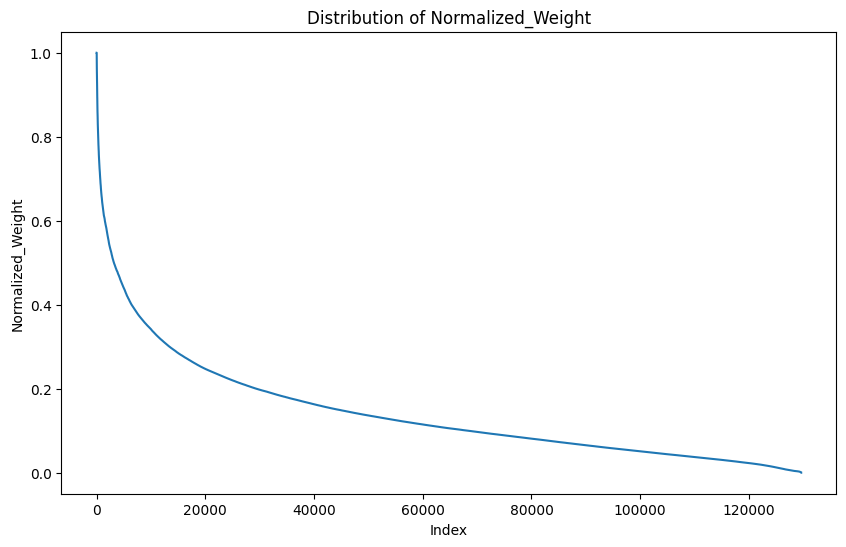

In [23]:
# 모든 DataFrame의 Normalized_Weight 값을 하나의 리스트로 결합
all_weights = pd.concat([df['Normalized_Weight'] for df in dfs])

# Normalized_Weight 값을 내림차순으로 정렬
weights_sorted = sorted(all_weights, reverse=True)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(weights_sorted)
plt.xlabel('Index')
plt.ylabel('Normalized_Weight')
plt.title('Distribution of Normalized_Weight')
plt.show()

In [24]:
# Elbow Method를 사용하여 최적의 N 선택
kneedle = KneeLocator(range(len(weights_sorted)), weights_sorted, curve='convex', direction='decreasing')
optimal_N = kneedle.elbow
print(f"Optimal N: {optimal_N}")


Optimal N: 0


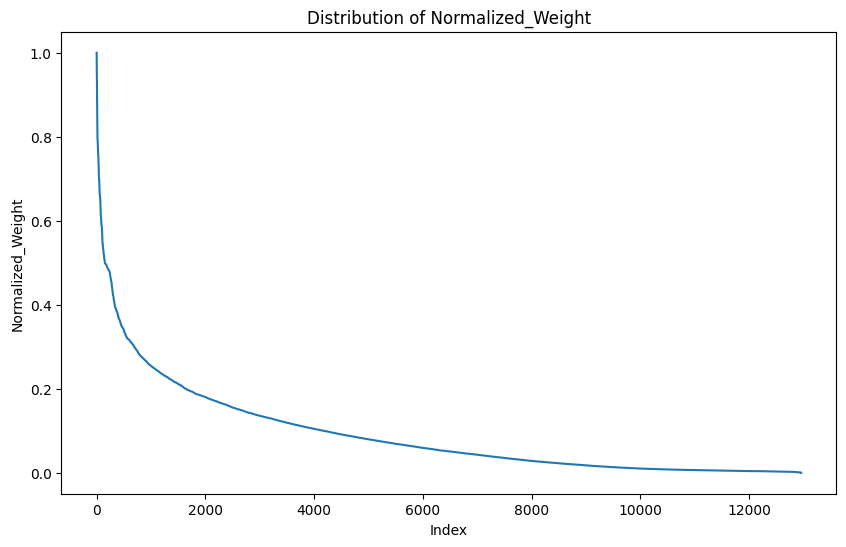

In [27]:
# 모든 Normalized_Weight 값을 하나의 리스트로 결합

weights = dfs[6]['Normalized_Weight']

# Normalized_Weight 값을 내림차순으로 정렬
weights_sorted = sorted(weights, reverse=True)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(weights_sorted)
plt.xlabel('Index')
plt.ylabel('Normalized_Weight')
plt.title('Distribution of Normalized_Weight')
plt.show()


In [73]:
# Elbow Method를 사용하여 최적의 N 선택
kneedle = KneeLocator(range(len(weights_sorted)), weights_sorted, curve='convex', direction='decreasing')
optimal_N = kneedle.elbow
print(f"Optimal N: {optimal_N}")


Optimal N: 220


In [74]:
# 각 데이터프레임의 optimal_N 값을 저장할 리스트
optimal_N_list = []

for df in dfs:
    weights_sorted = sorted(df['Normalized_Weight'], reverse=True)
    kneedle = KneeLocator(range(len(weights_sorted)), weights_sorted, curve='convex', direction='decreasing')
    optimal_N = kneedle.elbow
    optimal_N_list.append(optimal_N)

# Optimal N 값 확인
print("Optimal N values for each dataframe:")
print(optimal_N_list)


Optimal N values for each dataframe:
[167, 255, 319, 229, 378, 114, 2, 303, 358, 184]


In [75]:
# Optimal N 값의 평균 계산
average_optimal_N = int(np.mean([n for n in optimal_N_list if n is not None]))
print(f"Average Optimal N: {average_optimal_N}")

Average Optimal N: 230


In [76]:
12962*0.05

648.1

In [23]:
# Generate list of files based on filename pattern
path = 'res/'

class_names = ['Tip_Cells', 'activated_capillary', 'Immature_Phenotype',
               'capillary_I', 'capillary_II', 'Activated_EC', 'TandNK', 
               'Epithelial', 'Myeloid', 'Fibro_Peri', 'B']

for cell in class_names:
    file_list = [f for f in os.listdir(path) 
                 if f.startswith("gcamplus_result_" + cell + "_v") and f.endswith(".txt")]

    dfs = []
    
    # Iterate over the file list, create dataframes and append to the list
    for file in sorted(file_list):
        df = pd.read_csv(path + file, sep='\t')
        df = df.sort_values(by='Normalized_Weight', ascending=False).reset_index(drop=True)
        dfs.append(df)
    
    # Ensure dfs is not empty before calculating ref_value
    if dfs:
        ref_value = int(len(dfs[0].index) * 0.05)
    
    filtered_dfs = []
    for df in dfs:
        # Filter by top ref_value
        filtered_df = df.head(n=ref_value)
        filtered_dfs.append(filtered_df)
    
    # Calculate the occurrence of gene pairs
    gene_pairs = []
    tumor = df.columns[0]
    other = df.columns[1]
    
    # Count the number of TumorCell and TEC pairs
    for df in filtered_dfs:
        for index, row in df.iterrows():
            gene_pairs.append((row[tumor], row[other]))
    
    # Convert list to dataframe
    common_pairs_df = pd.DataFrame(gene_pairs, columns=[tumor, other])
    
    # Calculate the frequency of TumorCell and TEC pairs
    common_pairs_df['Count'] = common_pairs_df.groupby([tumor, other])[other].transform('count')
    
    # Remove duplicates
    common_pairs_df = common_pairs_df.drop_duplicates().reset_index(drop=True)
    
    # Sort by count in descending order
    common_pairs_df_50 = common_pairs_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

    # Count the occurrences of gene pairs
    gene_pair_counts = {}
    for df in filtered_dfs:
        for index, row in df.iterrows():
            pair = (row[df.columns[0]], row[df.columns[1]])
            gene_pair_counts[pair] = gene_pair_counts.get(pair, 0) + 1
    
    # Collect Normalized_Weight values for each gene pair
    gene_pair_weights = {pair: [] for pair in gene_pair_counts.keys()}
    for df in filtered_dfs:
        for index, row in df.iterrows():
            pair = (row[df.columns[0]], row[df.columns[1]])
            if pair in gene_pair_weights:
                gene_pair_weights[pair].append(row[df.columns[2]])
    
    # Perform statistical analysis (mean, variance, std deviation, median)
    stats_results = []
    for pair, weights in gene_pair_weights.items():
        if weights:  # Only compute if weights list is not empty
            mean_weight = np.mean(weights)
            variance_weight = np.var(weights)
            std_dev_weight = np.std(weights)  # Compute std deviation
            median_weight = np.median(weights)  # Compute median
            cv_weight = std_dev_weight / mean_weight * 100 if mean_weight else 0  # Compute CV
            stats_results.append({
                df.columns[0]: pair[0],
                df.columns[1]: pair[1],
                'Mean Normalized_Weight': mean_weight,
                'Variance Normalized_Weight': variance_weight,
                'Std Dev Normalized_Weight': std_dev_weight,  # Added std deviation
                'Median Normalized_Weight': median_weight,  # Added median
                'CV Normalized_Weight': cv_weight,  # Added CV
                'Count': gene_pair_counts[pair]
            })
    
    stats_df = pd.DataFrame(stats_results)
    
    # Sort the results dataframe by count
    stats_df_sorted = stats_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

    # Save the results
    stats_df_sorted.set_index(stats_df_sorted.columns[0], inplace=True)
    file_name = "gcam_" + cell + "_res.csv"
    stats_df_sorted.to_csv(path + file_name)
    print(f"Completed: {file_name}")


Completed: gcam_Tip_Cells_res.csv
Completed: gcam_activated capillary_res.csv
Completed: gcam_Immature_Phenotype_res.csv
Completed: gcam_capillary_I_res.csv
Completed: gcam_capillary_II_res.csv
Completed: gcam_Activated_EC_res.csv
Completed: gcam_TandNK_res.csv
Completed: gcam_Epithelial_res.csv
Completed: gcam_Myeloid_res.csv
Completed: gcam_Fibro_Peri_res.csv
Completed: gcam_B_res.csv
